# Creacion de modelo

Datos de entrenamiento: 13,881
Datos de prueba: 3,471

🔄 Entrenando Linear Regression...
Train MAE: 23.18
Test MAE: 26.55
Train RMSE: 30.16
Test RMSE: 34.29
Test R²: 0.8240

🔄 Entrenando Random Forest...
Train MAE: 6.65
Test MAE: 34.15
Train RMSE: 8.97
Test RMSE: 42.58
Test R²: 0.7287

📊 Comparación de modelos:
               Model  Test MAE  Test RMSE  Test R²
0  Linear Regression   26.5525    34.2948   0.8240
1      Random Forest   34.1455    42.5753   0.7287


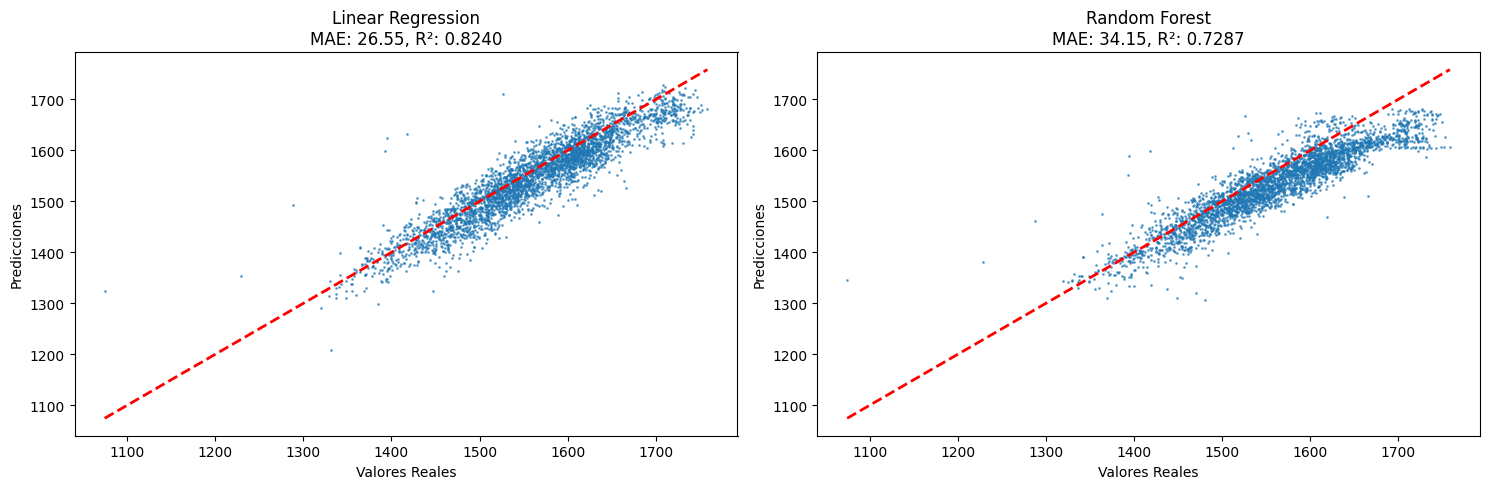


✅ Mejor modelo guardado: Linear Regression
Archivo: ../models/best_model.pkl
Info del modelo guardada en: ../models/model_info.pkl


In [1]:
# Creacion de modelo

## Objetivo
### ✔ entrenar por primera vez
### ✔ medir error real
### ✔ entender que el modelo puede mejorar

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
import joblib
import os

# Cargar datos con features
df = pd.read_csv("../data/processed/industrial_timeseries_featured.csv", parse_dates=["timestamp"])

# Seleccionar features para el modelo
feature_columns = [
    'temperature', 'demand_factor', 'operational_efficiency', 'energy_price',
    'hour', 'day_of_week', 'month', 'is_weekend',
    'lag_1h', 'lag_24h', 'rolling_mean_24h', 'rolling_std_24h',
    'temp_squared', 'demand_efficiency_interaction'
]

X = df[feature_columns]
y = df["value"]

# Split manteniendo orden temporal
split_idx = int(len(df) * 0.8)
X_train, X_test = X[:split_idx], X[split_idx:]
y_train, y_test = y[:split_idx], y[split_idx:]

print(f"Datos de entrenamiento: {len(X_train):,}")
print(f"Datos de prueba: {len(X_test):,}")

# Entrenar múltiples modelos
models = {
    'Linear Regression': LinearRegression(),
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42)
}

results = {}

for name, model in models.items():
    print(f"\n🔄 Entrenando {name}...")
    
    # Entrenar
    model.fit(X_train, y_train)
    
    # Predicciones
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)
    
    # Métricas
    train_mae = mean_absolute_error(y_train, y_pred_train)
    test_mae = mean_absolute_error(y_test, y_pred_test)
    train_rmse = np.sqrt(mean_squared_error(y_train, y_pred_train))
    test_rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))
    train_r2 = r2_score(y_train, y_pred_train)
    test_r2 = r2_score(y_test, y_pred_test)
    
    results[name] = {
        'model': model,
        'train_mae': train_mae,
        'test_mae': test_mae,
        'train_rmse': train_rmse,
        'test_rmse': test_rmse,
        'train_r2': train_r2,
        'test_r2': test_r2,
        'y_pred_test': y_pred_test
    }
    
    print(f"Train MAE: {train_mae:.2f}")
    print(f"Test MAE: {test_mae:.2f}")
    print(f"Train RMSE: {train_rmse:.2f}")
    print(f"Test RMSE: {test_rmse:.2f}")
    print(f"Test R²: {test_r2:.4f}")

# Comparación de modelos
print("\n📊 Comparación de modelos:")
comparison_df = pd.DataFrame({
    'Model': list(results.keys()),
    'Test MAE': [results[name]['test_mae'] for name in results.keys()],
    'Test RMSE': [results[name]['test_rmse'] for name in results.keys()],
    'Test R²': [results[name]['test_r2'] for name in results.keys()]
})
print(comparison_df.round(4))

# Visualizar predicciones vs valores reales
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

for i, (name, result) in enumerate(results.items()):
    axes[i].scatter(y_test, result['y_pred_test'], alpha=0.6, s=1)
    axes[i].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
    axes[i].set_xlabel('Valores Reales')
    axes[i].set_ylabel('Predicciones')
    axes[i].set_title(f'{name}\nMAE: {result["test_mae"]:.2f}, R²: {result["test_r2"]:.4f}')

plt.tight_layout()
plt.show()

# Guardar el mejor modelo
best_model_name = min(results.keys(), key=lambda x: results[x]['test_mae'])
best_model = results[best_model_name]['model']

# Crear directorio de modelos si no existe
os.makedirs("../models", exist_ok=True)

joblib.dump(best_model, "../models/best_model.pkl")
print(f"\n✅ Mejor modelo guardado: {best_model_name}")
print(f"Archivo: ../models/best_model.pkl")

# Guardar información de features
feature_info = {
    'features': feature_columns,
    'model_type': best_model_name,
    'test_mae': results[best_model_name]['test_mae']
}

joblib.dump(feature_info, "../models/model_info.pkl")
print(f"Info del modelo guardada en: ../models/model_info.pkl")